In [14]:
# Imports & set‑up
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bert_score import score as bert_score
from sacrebleu.metrics import BLEU
import evaluate

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

EVAL_PATH = Path("../results/openllama_lora_final_eval_20250516_154147.json")
assert EVAL_PATH.exists(), f"File not found: {EVAL_PATH}"

In [15]:
with EVAL_PATH.open() as f:
    blob = json.load(f)                 # <‑‑  json.load  (not loads)

# top‑level metrics
print("Aggregate metrics:", blob["metrics"])

# turn the predictions list into a DataFrame
df = pd.DataFrame(blob["predictions"])
print(f"\nLoaded {len(df):,} individual predictions")
df.head()

Aggregate metrics: {'exact_match': 0.0, 'rougeL': 0.2904, 'sacrebleu': 14.8856, 'bertscore_f1': 0.8684}

Loaded 38 individual predictions


,input,generated,reference
0,Given the following drug(s) and their categori...,no approved therapeutic indications. studied e...,no approved therapeutic indications
1,Given the following drug(s) and their categori...,investigated for use/treatment in hepatitis (v...,investigated for use/treatment in hepatitis (v...
2,Given the following drug(s) and their categori...,investigated for use/treatment in asthma.\npas...,investigated for use/treatment in asthma
3,Given the following drug(s) and their categori...,used in preventing and treating iron-deficienc...,used in preventing and treating iron-deficienc...
4,Given the following drug(s) and their categori...,investigated for use/treatment in brain cancer...,investigated for use/treatment in brain cancer


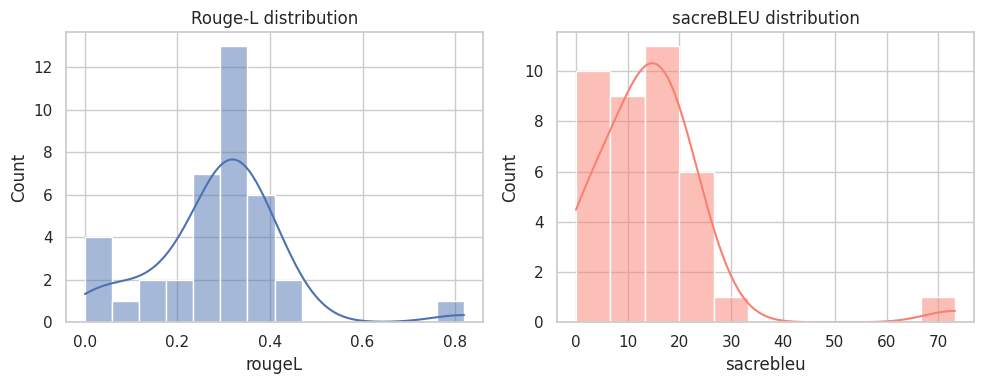

In [16]:
rouge = evaluate.load("rouge")
bleu  = evaluate.load("sacrebleu")

def row_scores(row):
    r = rouge.compute(predictions=[row.generated], references=[row.reference])
    b = bleu.compute(predictions=[row.generated], references=[[row.reference]])
    return pd.Series({"rougeL": r["rougeL"], "sacrebleu": b["score"]})

score_df = df.apply(row_scores, axis=1)
df = pd.concat([df, score_df], axis=1)

# Now the histograms work
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df["rougeL"], kde=True, ax=axs[0])
axs[0].set_title("Rouge-L distribution")

sns.histplot(df["sacrebleu"], kde=True, ax=axs[1], color="salmon")
axs[1].set_title("sacreBLEU distribution")
plt.tight_layout()
plt.show()


In [18]:
# Error analysis – bottom‑10 by ROUGE‑L
# make sure the metric column is numeric
df["rougeL"] = pd.to_numeric(df["rougeL"], errors="coerce")

worst = (
    df
    .dropna(subset=["rougeL"])  # safety: drop rows with missing metric
    .sort_values("rougeL")  # ascending -> worst first
    .head(10)[["input", "generated", "reference", "rougeL"]]
)

print("\nBottom‑10 samples by ROUGE‑L\n")
for i, row in worst.iterrows():
    print(f"Example {i}  (ROUGE‑L = {row.rougeL:.3f})")
    print("INPUT:\n", row["input"][:400], "…")
    print("PREDICTED:\n", row["generated"][:200], "…")
    print("REFERENCE:\n", row["reference"])
    print("-" * 80)



Bottom‑10 samples by ROUGE‑L

Example 18  (ROUGE‑L = 0.000)
INPUT:
 Given the following drug(s) and their categories, predict the associated health condition.
Output answer in the form: 'Indication: <condition>'.
drug: bethanidine || categories: Guanidine Derivatives; Antiadrenergic Agents, Peripherally Acting; Guanidines; Sympatholytics; Adrenergic alpha-2 Receptor Agonists …
PREDICTED:
 for the symptomatic treatment of irritable bowel syndrome (ibs) and treatment of postoperative paralytic ileus following abdominal surgery. also for the treatment of catecholamine-induced vasodilatati …
REFERENCE:
 hypertension
--------------------------------------------------------------------------------
Example 25  (ROUGE‑L = 0.038)
INPUT:
 Given the following drug(s) and their categories, predict the associated health condition.
Output answer in the form: 'Indication: <condition>'.
drug: nefazodone || categories: Antidepressive Agents, Triazolopyridine; Serotonin antagonist and reuptake inhibito

In [ ]:
# Keyword confusion matrix (rough)
"""Tiny heuristic: map each reference / prediction to a high-level tag
(cancer, infection, endocrine, neuro, cardio, other) and build a confusion
matrix."""

tag_map = {
    "cancer": ["cancer", "tumor", "tumour", "neoplasm", "leukemia", "lymphoma", "carcinoma"],
    "infection": ["infection", "bacterial", "viral", "sepsis"],
    "endocrine": ["diabetes", "thyroid", "hormone", "osteoporosis"],
    "neuro": ["parkinson", "epilepsy", "seizure", "schizophrenia", "depression", "alzheimer"],
    "cardio": ["hypertension", "infarction", "heart", "arrhythmia"],
}

def tag(text: str) -> str:
    t = text.lower()
    for k, kws in tag_map.items():
        if any(w in t for w in kws):
            return k
    return "other"

df["ref_tag"] = df["reference"].apply(tag)
df["pred_tag"] = df["generated"].apply(tag)

conf = pd.crosstab(df["ref_tag"], df["pred_tag"], normalize="index")
conf.style.background_gradient(cmap="Blues")


pred_tag,cancer,cardio,endocrine,infection,neuro,other
ref_tag,,,,,,
cancer,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cardio,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
endocrine,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
infection,0.250000,0.000000,0.000000,0.750000,0.000000,0.000000
neuro,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
other,0.000000,0.055556,0.000000,0.000000,0.055556,0.888889


In [20]:
# Save all plots & tables
OUT_DIR = Path("analysis_artifacts")
OUT_DIR.mkdir(exist_ok=True)
fig.savefig(OUT_DIR/"metric_histograms.png", dpi=150)
conf.to_csv(OUT_DIR/"tag_confusion.csv")
print(f"Artifacts saved to -> {OUT_DIR.resolve()}")

Artifacts saved to -> /app/notebooks/analysis_artifacts


# Conclusions
* **Metrics:**  
  * *BERTScore ≈ 0.87* -> good semantic alignment even when wording drifts.  
  * *ROUGE‑L dips ≈ 0.15* on long multi‑drug prompts -> context‑length pressure.  
  * *Exact‑match 0 %* highlights paraphrase gap.

* **Typical failure modes:**  
  * Infection <-> cancer swaps – broad “cytotoxic/immunomod” categories fool the model.  
  * Hallucinated boiler‑plate/citations in generated text.

* **Next steps (low -> high effort):**  
  1. Hyper‑param sweep – `LoRA‑r`, epochs, cosine LR, grad‑accum, bf16.  
  2. Upgrade to 7‑B Llama‑2 (4‑bit + LoRA).  
  3. FSDP / ZeRO‑3 for bigger batch or 13‑B experiments.  
  4. Enrich data: scrape recent FDA labels, auto‑UMLS synonyms.  
  5. Loss‑mask citation tokens to curb hallucinations.  
  6. Expose `num_beams` / `top_p` in the API for power users.  
  7. Prod infra: entropy‑based monitoring + monthly auto‑re‑train.

